In [49]:
import mygrad as mg
from mynn.initializers.he_normal import he_normal

from datasets import ToyData
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

try:
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass

In this notebook, we will be training a two-layer neural network to solve a *classification* problem on a toy data set. We will generate a spiral-formation of 2D data points. This spiral will have grouped "tendrils", and we will want our neural network to classify *to which tendril a given point belongs*. 

Read the documentation for `ToyData`. Run the following cells to view the spiral data set.

In [50]:
# Constructing the spiral dataset and its labels.
num_tendril = 3
data = ToyData(num_classes=num_tendril)

# Convert the data and labels to a datatype suitable for an `oxen` model.
xtrain, ytrain, xtest, ytest = data.load_data()

<IPython.core.display.Javascript object>


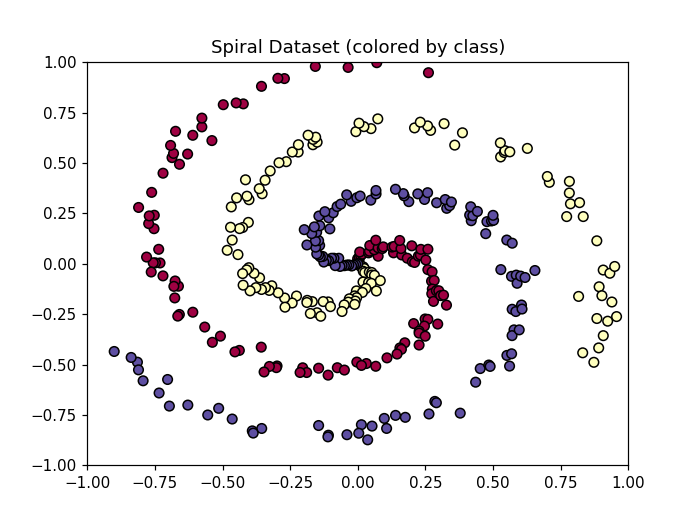

In [51]:
fig, ax = data.plot_spiraldata()

View the contents of `xtrain` and `ytrain`. What do these arrays correspond to? See that `xtrain` stores the 2D data points in the spiral, and `ytrain` stores the Tendril-ID associated with that point. How many points are in our training data? How are the labels specified for this dataset? Which label corresponds to which tendril? Discuss with your neighbor.

*SOLUTION HERE*

In [52]:
#print(xtrain)
#print(ytrain)

## Our Model

We will extend the universal function approximation function to make a *classification* prediction. That is, given a 2D point $\vec{x}$, our model will product $\vec{y}_{pred} = [y_0, y_1, y_2]$, where $y_i$ indicates how "confident" our model is that $\vec{x}$ belongs to tendril-$i$. 

\begin{equation}
F(\{\vec{v}_i\}, \{\vec{w}_i\}, \{b_i\}; \vec{x}) = \sum_{i=1}^{N} \vec{v}_{i}\varphi(\vec{x} \cdot \vec{w}_{i} + b_{i}) = \vec{y}_{pred}
\end{equation}

Notice here that $\vec{v}_i$ is now a *vector*, whereas in the original universal function approximation theorem it was a scalar. This is in accordance with the fact that we now want to *predict* a vector, $\vec{y}_{pred}$, instead of a single number $y_{pred}$.

What should the dimensionality of each $\vec{v}_i$ be? Discuss with a neighbor.

Create a two-layer dense neural network that closely resembles that one that you constructed as the universal approximator for the 1D functions. This time, however, $\vec{x}$ will be a 2D point instead of a single number. Thus a batch of our training data will have a shape $(M, 2)$ instead of $(M, 1)$. 

Because we are classifying which of three tendrils a 2D point belongs to, we now **want our model to predict *three* numbers**, rather than one, as its prediction (that is, it will produce three number per 2D point in the training batch). These three numbers will be the three "scores" that our model predicts for a point: one for each tendril. If score-0 is the largest score, then our model is predicting that the 2D point belongs to tendril 0. And so on. Thus the final layer of our network will have the shape $(M, 3)$ rather than $(M, 1)$. 

## The "Activation" Function

We will be using the so-called "activation function":

\begin{equation}
\varphi(x) = 
\begin{cases} 
      0, \quad x < 0 \\
      x, \quad 0 \leq x
\end{cases}
\end{equation}

which is known as a "rectified linear unit", or ReLU for short. This is a very popular activation function in the world of deep learning. We will not have time to go into why here, but it is worthwhile to read about. `mygrad` has this function: `mygrad.nnet.activations.relu`.

(The astute reader will note that ReLU does not satisfy the requirements on $\varphi(x)$, as dictated by the universal function theorem. Which requirement does this violate?) 

Import the relu function from `mygrad`, and plot it on $x \in [-3, 3]$. What does the derivative of this function look like? Plot it as well.

<IPython.core.display.Javascript object>


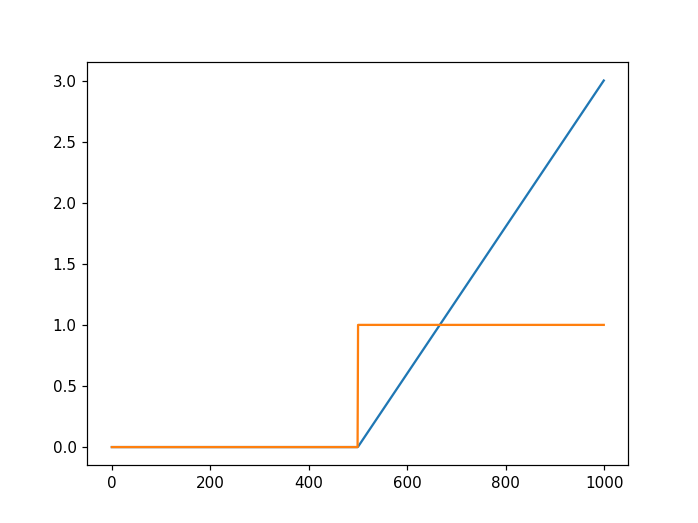

In [53]:
from mygrad.nnet import relu

x_vals = mg.linspace(-3, 3, num=1000)

relu1 = relu(x_vals)

img, ax = plt.subplots()

ax.plot(relu1)

relu1.backward()

#print(x_vals.grad)
ax.plot(x_vals.grad)

### Initializing Our Model Parameters
We will be using a intialization technique known as "He-normal" initialization (pronounced "hey"). Essentially we will draw all of our dense-layer parameters from a scaled normal distribution, where the distribution will scaled by an additional $\frac{1}{\sqrt{2N}}$, where $N$ is dictates that number of parameters among $\{\vec{v}_i\}_{i=0}^{N-1}$, $\{\vec{w}_i\}_{i=0}^{N-1}$, and $\{b_i\}_{i=0}^{N-1}$, respectively. This will aid us when we begin training neural networks with large numbers of neurons.

Import this initialization function from `MyNN`: `from mynn.initializers.he_normal import he_normal`. Use this instead of `numpy.random.randn`.

In [54]:
from mynn.initializers.he_normal import he_normal

def create_parameters(n):
    """ Randomly initializes the parameters w and v by drawing from 
    a He-normal distribution. 
    
    Initialize each b to be 0
    
    Parameters
    ----------
    n : int 
        The number of parameters to use in our function approximator for
        w, b, and v.

    Returns
    -------
    Tuple[Tensor, Tensor, Tensor]
        Returns w, b, v

    Notes
    -----
    w: shape-(2, n)  # 2 is the dimensionality of each point, x
    b: shape-(n,)
    v: shape-(n, num_class)"""
    w = he_normal(2, n)
    b = mg.zeros(n)
    v = he_normal(n, 3)
    return w, b, v

## Computing Accuracy

Because we are solving a classification problem rather than a regression problem, we can measure the accuracy of our predictions. Write an `accuracy` function which accepts our models predictive scores for a batch of data, shape-(M, 3), and the "truth" labels for that batch, shape-(M,). 

Thus, if score-0 for some point is the maximum score, and the label for that point is 0, then the prediction for that point is correct. 

The function should return the mean classification accuracy for that batch of predictions (a single number between 0 and 1). Write a simple test for your function.

In [55]:
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
        
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
        The accuracy: the fraction of predictions that your model got correct,
        which should be in [0, 1]"""
    return np.sum(np.argmax(predictions, axis=1) == truth) / len(predictions)

## Our Loss Function

### The softmax activation function

We will be using the "cross-entropy" function for our loss. This loss function is derived from the field of information theory, and is designed to compare probability distributions. This means that we will want to convert the numbers of $\vec{y}_{pred} = F(\{\vec{v}_i\}, \{\vec{w}_i\}, \{b_i\}; \vec{x})$, into numbers that behave like probabilities. To do this, we will use the "softmax" function:

Given an $m$-dimensional vector $\vec{y}$, the softmax function returns a a vector, $\vec{p}$ of the same dimensionality:


\begin{equation}
softmax(\vec{y}) = \vec{p}
\end{equation}

where

\begin{equation}
p_i = \frac{e^{y_{i}}}{\sum_{j=0}^{m-1}{e^{y_{j}}}}
\end{equation}

Convince yourself that the elements of $\vec{p}$ do indeed satisfy the basic requirements of being a probability distribution. I.e. :

- $0 \leq p_i \leq 1$, for each $p_i$
- $\sum_{i=0}^{m-1}{p_i} = 1$

where $m$ is the number of classes in our classification problem.

### The cross-entropy loss function

So, armed with the softmax function, we can convert our classification scores, $\vec{y}$, to classification probabilities, $\vec{p}$ (or at the very least, numbers that *act* like probabilities. This opens the door for us to utilize the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy).

Given our prediction probabilities for the $m$ classes in our problem, $\vec{p}$, we have the associated "true" probabilities $\vec{t}$ (since we are solving a supervised learning problem). E.g., 

- if our point $\vec{x}$ resides in tendril-0, then $\vec{t} = [1., 0., 0.]$
- if our point $\vec{x}$ resides in tendril-1, then $\vec{t} = [0., 1., 0.]$
- if our point $\vec{x}$ resides in tendril-2, then $\vec{t} = [0., 0., 1.]$

In terms of our predictions, $\vec{p}$, and our truth-values, $\vec{t}$, the cross-entropy loss is:

\begin{equation}
\mathscr{L}(\vec{p}, \vec{t}) = -\sum_{i=0}^{m}{t_{i}\log{p_{i}}}
\end{equation}

This loss function measures *how different two probability distributions, $\vec{p}$ and $\vec{t}$ are*. The loss gets larger as the two probability distributions become more disparate, and the loss is a minimum (0) when the two distributions are identical.

In the case we only have two classes, such that $\vec{p}=\begin{bmatrix}p, & 1-p\end{bmatrix}$ and $\vec{t}=\begin{bmatrix}t, & 1-t\end{bmatrix}$, we can actually visualize our loss function as below:

![loss](pics/loss.png)

---

Is this what you expect to see from the loss function? Discuss with a partner.

## The softmax-crossentropy function

Because it is very common to perform the softmax on the outputs of your model, to "convert them to probabilities", and then pass those probabilities to a cross-entropy function, it is more efficient to have a function that does both of these steps. This is what `mygrad`'s [softmax_crossentropy](https://mygrad.readthedocs.io/en/latest/generated/mygrad.nnet.softmax_crossentropy.html) function does. Take the time to read its documentation.


In [56]:
from mygrad.nnet.losses import softmax_crossentropy

## Defining your gradient descent and forward pass functions

In [57]:
def grad_descent(params, learning_rate):
    """ Update tensors according to vanilla gradient descent.
    
        Parameters
        ----------
        params : Iterable[mygrad.Tensor]
            A list/tuple of learnable parameters to be updated
            
        learning_rate : float
            The 'step size' to use during the descent
        
        Returns
        -------
        None
            Each parameter in the list should be updated 'in-place'"""
    # STUDENT CODE HERE
    for tensor in params:
        tensor.data -= tensor.grad * learning_rate
    
def forward_pass(x, w, b, v):
    """ 
    The approximating function, evaluated at F(xj) for j=1,...,M.
    
    Parameters
    ----------
    x : numpy.ndarray, shape=(M, 2)
    w : mygrad.Tensor, shape=(2, N)
    b : mygrad.Tensor, shape=(N, )
    v : mygrad.Tensor, shape=(N, num_class)
    
    Returns
    -------
    mygrad.Tensor, shape=(M, num_class)
        The M predictions produced by your model. F(xj) for j=1,...,M
    """
    out1 = relu(mg.matmul(x, w) + b)  # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)
    model_out = mg.matmul(out1, v)       # matmul[(M, N) w/ (N, 1)] --> (M, 1)
    return model_out

Initialize your noggin plotter so that it will track two metrics: loss and accuracy

```python
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])
```

Also, initialize your model parameters and batch-size. 
- Start off with a small number of neurons in your layer - try $N=3$. Increase number of parameters in your model to improve the quality of your result. You can use the visualization that we provide at the end of this notebook to get a qualitative feel for your notebook
- A batch-size of 50 is fine, but feel free to experiment.

<IPython.core.display.Javascript object>


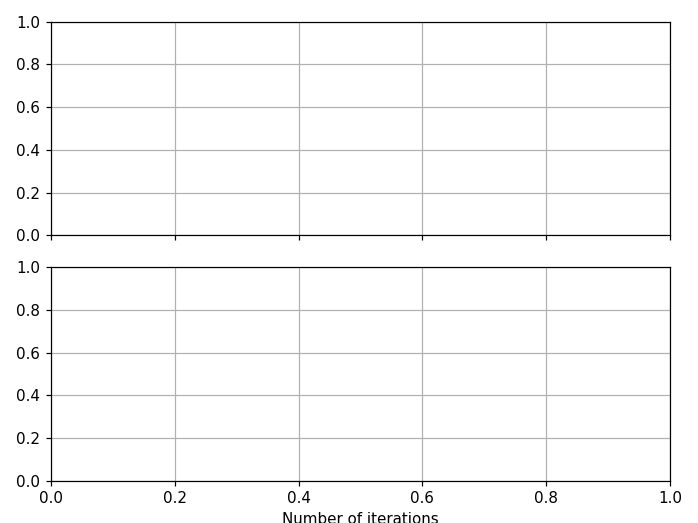

In [61]:
# Running this code will recreate your model, re-initializing all of its parameters
# Thus you must re-run this cell if you want to train your model from scratch again.

# - Create the noggin figure using the code snippet above
# - Set `batch_size = 50`: the number of predictions that we will make in each training step
# - Create your paramters: w, b, and v; 

# STUDENT CODE HERE
from noggin import create_plot

plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])
batch_size = 50
w, b, v = create_parameters(10_000)

Referring to the code that you used to train your universal function approximator, write code to train your model on the spiral dataset for a specified number of epochs. Remember to shuffle your training data before you form batches out of it. Also, remember to use the the `softmax_crossentropy` loss.

Try training your model for 1000 epochs. A learning rate $\approx 0.1$ is a sensible starting point. Watch the loss and accuracy curves evolve as your model trains.

Below, you will be able to visualize the "decision boundaries" that your neural network learned. Try adjusting the number of neurons in your model, the number of epochs trained, the batch size, and the learning rate. 

In [60]:
# Here 
# import the loss function from mygrad, as directed above
# STUDENT CODE HERE
from mygrad.nnet import softmax_crossentropy
from mygrad.nnet.activations import sigmoid

# specify your learning rate
# STUDENT CODE HERE
lr = 0.001

for epoch_cnt in range(3_000):
    
    # `idxs` will store shuffled indices, used to randomize the batches for 
    # each epoch
    idxs = np.arange(len(xtrain))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, len(xtrain)//batch_size):
        # get the batch-indices from `idxs` (refer to the universal function approx notebook)
        # STUDENT CODE HERE
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]

        # index into `xtrain` and `ytrain` with these indices to produce 
        # the batch of data and the associated tendril-labels for this batch
        # STUDENT CODE HERE
        batch_data = xtrain[batch_indices]
        labels = ytrain[batch_indices]
        
        # make predictions with your model
        # STUDENT CODE HERE
        predict = forward_pass(batch_data, w, b, v)
        
        # Compute the loss and accuracy associated with our predictions
        # The loss should be a Tensor so that you can do back-prop
        # The accuracy should just be a floating point number
        # STUDENT CODE HERE
        loss = softmax_crossentropy(predict, labels)
        acc = accuracy(predict, labels)
        
        # Trigger back-propagation through your computational graph,
        # so that dL/dw, dL/db, and dL/dv are computed
        # STUDENT CODE HERE
        loss.backward()
        
        # Perform gradient descent and then null your gradients
        # STUDENT CODE HERE
        grad_descent([w, b, v], lr)
        loss.null_gradients()
        
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
plotter.plot()
print(acc)

0.88


In [59]:
stored_w, stored_b, stored_v = np.copy(w), np.copy(b), np.copy(v)

This cell will allow you to visualize the decision boundaries that your model learned. We must define a function whose only input is the data, and whose out output is the softmax (**not** softmax crossentropy) of your classification scores.

For this to work, the parameters that you defined for your model must have the names `w`, `b`, `v`, as used below (ask for help if this isn't working for you).

<IPython.core.display.Javascript object>


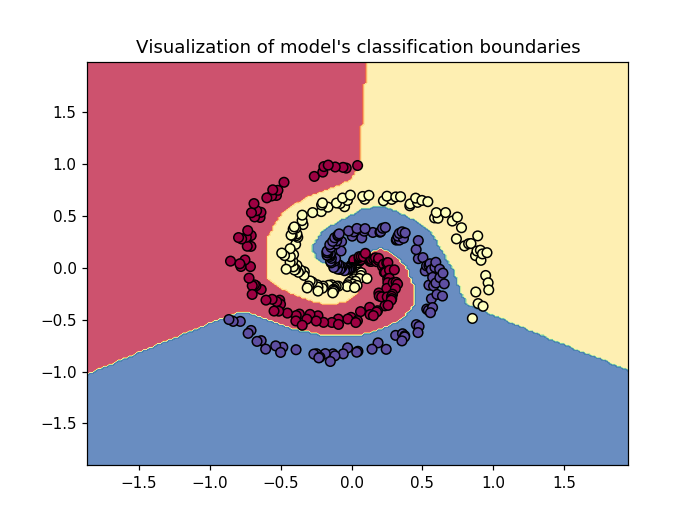

In [48]:
def dummy_function(x):
    from mygrad.nnet.activations import softmax
    return softmax(forward_pass(x, w, b, v)).data

fig, ax = data.visualize_model(dummy_function, entropy=False);